# Testing Facebook Prophet
For time series predictions on Crypto

In [11]:
# Libraries
from tqdm import tqdm
import pandas as pd
from prophet import Prophet
import yfinance as yf
from datetime import datetime, timedelta
import plotly.express as px
from sklearn.metrics import mean_squared_error
from math import sqrt

# 1.  Acquiring and Preprocessing Data

## Getting Prices 
From 2 years ago til now

In [83]:
# Time periods
now = datetime.now()

# How far back to retrieve tweets
ago = now - timedelta(days=730)

# Designating the Ticker
crypto = yf.Ticker("BTC-USD")

# Getting price history
df = crypto.history(start=ago.strftime("%Y-%m-%d"), end=now.strftime("%Y-%m-%d"), interval="1d")

## Some Data Preprocessing

In [84]:
# Getting the N Day Moving Average and rounding the values
df['MA'] = df[['Open']].rolling(window=5).mean().apply(lambda x: round(x, 2))

# Dropping the NaNs
df.dropna(inplace=True)

## Formatting DF for FB Prophet

In [85]:
# Formatted
df = df.reset_index().rename(columns={"Date": "ds", "MA": "y"})
df

,ds,Open,High,Low,Close,Volume,Dividends,Stock Splits,y
0,2019-09-22,10024.115234,10074.444336,9922.533203,10070.392578,13199651698,0,0,10147.28
1,2019-09-23,10067.962891,10074.238281,9727.143555,9729.324219,15144925408,0,0,10053.50
2,2019-09-24,9729.321289,9804.317383,8370.801758,8620.566406,25002886689,0,0,9724.33
3,2019-09-25,8603.428711,8744.828125,8325.396484,8486.993164,21744728353,0,0,9385.40
4,2019-09-26,8487.669922,8515.685547,7895.629395,8118.967773,19258205289,0,0,9005.25
...,...,...,...,...,...,...,...,...,...
718,2021-09-13,46057.214844,46598.679688,43591.320312,44963.074219,40969943253,0,0,45500.63
719,2021-09-14,44960.050781,47218.125000,44752.332031,47092.492188,38652152880,0,0,45640.84
720,2021-09-15,47098.000000,48450.468750,46773.328125,48176.347656,30484496466,0,0,46299.33
721,2021-09-16,48158.906250,48486.828125,47079.558594,47783.359375,31764293754,0,0,46815.71


# 2. Training and Predicting with the Model

## Fitting to FB Prophet

In [86]:
# Setting up Prophet
m = Prophet(
    daily_seasonality=True, 
    yearly_seasonality=True, 
    weekly_seasonality=True
)

# Fitting to the prices
m.fit(df[['ds', 'y']])

## Getting Future Dates for Forecast

In [87]:
# Future DF of 3 months
future = m.make_future_dataframe(periods=90)

## Forecasting Crypto Prices

In [88]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

,ds,yhat,yhat_lower,yhat_upper
0,2019-09-22,10496.517288,8063.360231,12876.752353
1,2019-09-23,10324.508010,8061.307887,12693.389876
2,2019-09-24,10160.489508,7826.220364,12563.826264
3,2019-09-25,9993.744673,7595.797309,12461.289776
4,2019-09-26,9816.513557,7227.914677,12047.858148
...,...,...,...,...
808,2021-12-12,71225.888909,63155.986124,79864.610390
809,2021-12-13,71434.249485,62941.146563,79987.989293
810,2021-12-14,71666.111661,63043.947339,80417.871443
811,2021-12-15,71914.605232,63021.939041,80405.462952


# 3. Visualizing Forecast

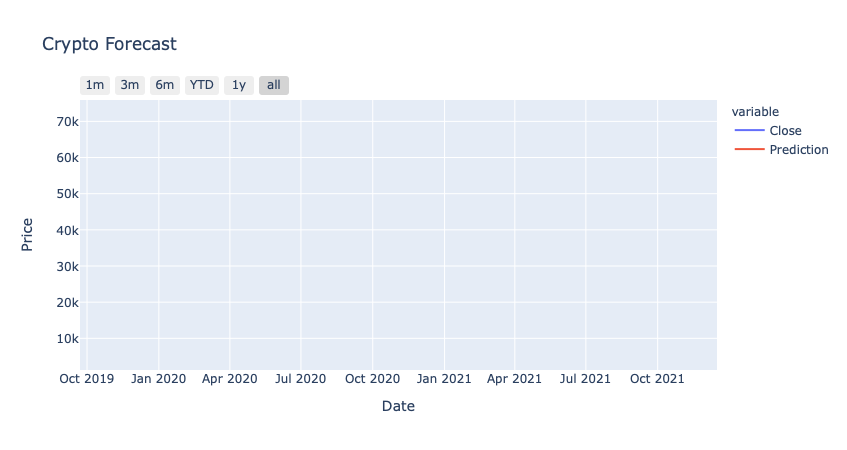

In [98]:
# Visual DF
vis_df = df[['ds','Open']].append(
    forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
).rename(columns={'yhat': 'Prediction'})

# Visualizing results
fig = px.line(
    vis_df,
    x='ds',
    y=['Open', 'Prediction'],
    title='Crypto Forecast',
    labels={'value':'Price',
            'ds': 'Date'}
)

# Adding a slider
fig.update_xaxes(
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=3, label="3m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)

fig.show()

# 4. Consolidated Previous Steps into Functions

In [2]:
def getData(ticker, window, ma_period):
    """
    Grabs price data from a given ticker. Retrieves prices based on the given time window; from now
    to N days ago.  Sets the moving average period for prediction. Returns a preprocessed DF
    formatted for FB Prophet.
    """
    # Time periods
    now = datetime.now()

    # How far back to retrieve tweets
    ago = now - timedelta(days=window)

    # Designating the Ticker
    crypto = yf.Ticker(ticker)

    # Getting price history
    df = crypto.history(start=ago.strftime("%Y-%m-%d"), end=now.strftime("%Y-%m-%d"), interval="1d")
    
    # Getting the N Day Moving Average and rounding the values
    df['MA'] = df[['Open']].rolling(window=5).mean().apply(lambda x: round(x, 2))

    # Dropping the NaNs
    df.dropna(inplace=True)

    # Formatted for FB Prophet
    df = df.reset_index().rename(columns={"Date": "ds", "MA": "y"})
    
    return df

In [3]:
def fbpTrainPredict(df, forecast_period):
    """
    Uses FB Prophet and fits to a appropriately formatted DF. Makes a prediction N days into 
    the future based on given forecast period. Returns predicted values as a DF.
    """
    # Setting up prophet
    m = Prophet(
        daily_seasonality=True, 
        yearly_seasonality=True, 
        weekly_seasonality=True
    )
    
    # Fitting to the prices
    m.fit(df[['ds', 'y']])
    
    # Future DF
    future = m.make_future_dataframe(periods=forecast_period)
        
    # Predicting values
    forecast = m.predict(future)

    # Returning a set of predicted values
    return forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

In [4]:
def visFBP(df, forecast):
    """
    Given two dataframes: before training df and a forecast df, returns
    a visual chart of the predicted values and actual values.
    """
    # Visual DF
    vis_df = df[['ds','Open']].append(forecast).rename(
        columns={'yhat': 'Prediction'}
    )

    # Visualizing results
    fig = px.line(
        vis_df,
        x='ds',
        y=['Open', 'Prediction'],
        title='Crypto Forecast',
        labels={'value':'Price',
                'ds': 'Date'}
    )

    # Adding a slider
    fig.update_xaxes(
        rangeselector=dict(
            buttons=list([
                dict(count=1, label="1m", step="month", stepmode="backward"),
                dict(count=3, label="3m", step="month", stepmode="backward"),
                dict(count=6, label="6m", step="month", stepmode="backward"),
                dict(count=1, label="YTD", step="year", stepmode="todate"),
                dict(count=1, label="1y", step="year", stepmode="backward"),
                dict(step="all")
            ])
        )
    )

    return fig.show()

## Running the Functions

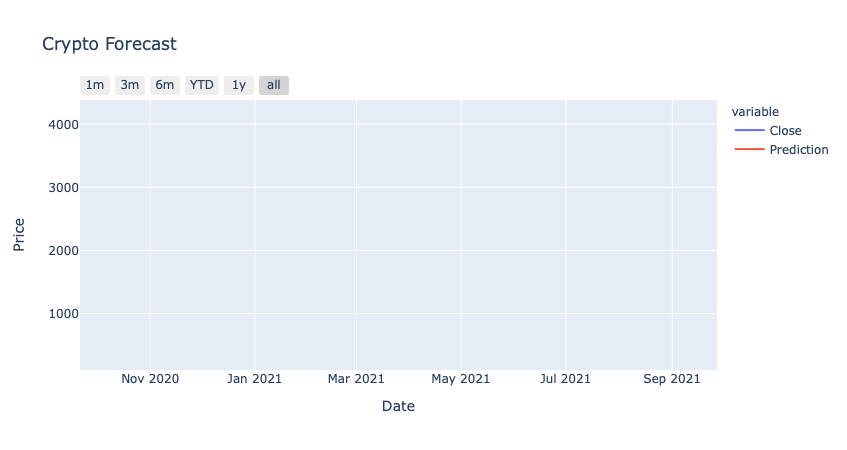

In [18]:
# Getting and Formatting Data
df = getData("ETH-USD", window=365, ma_period=21)

# Training and Predicting Data
forecast = fbpTrainPredict(df, forecast_period=10)

# Visualizing Data
visFBP(df, forecast)

# 5. Backtesting 
Using vectorization

In [15]:
def runningFBP(ticker, window=730, ma_period=5, days_to_train=365, forecast_period=10):
    """
    Runs the facebook prophet model over the provided ticker.  Trains with last N days given 
    by days_to_train.  Forecast N days into the future based on given forecast_period.  Moving average 
    is applied to the dataset based on given ma_period. Returns the root mean squared error and a DF 
    of the actual values and the predicted values for the same day.
    """

    # Getting and Formatting Data for 2 years
    df = getData("ETH-USD", window=window, ma_period=ma_period)

    # DF for the predicted values
    pred_df = pd.DataFrame()

    # Running the model on each day
    for i in tqdm(range(days_to_train,window)):

        # Training and Predicting
        forecast = fbpTrainPredict(df[i-days_to_train:i], 
                                   forecast_period=forecast_period).tail(1)[['ds','yhat']]

        # Adding the last day predicted
        pred_df = pred_df.append(forecast)

    # Combining the predicted df and original df
    df = df[['ds','Open']].merge(pred_df, on='ds', how='outer')

    # Shifting the prediction values back N days to compare them to the actual values
    df['yhat'] = df['yhat'].shift(-forecast_period)

    # Dropping the NaNs
    df.dropna(inplace=True)

    # Quick validation check on the predictions
    rmse = sqrt(mean_squared_error(df['Open'], df['yhat']))

    return {"df": df,
            "rmse": rmse}